In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import numpy as np
from tensorflow import keras
from os import mkdir
from tensorflow.keras import optimizers, metrics, initializers
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [11]:
thudohanoi_df.loc[thudohanoi_df.index.get_level_values(0) == 47, 'PM25'].values

array([26., 26., 28., ..., 39., 53., 58.])

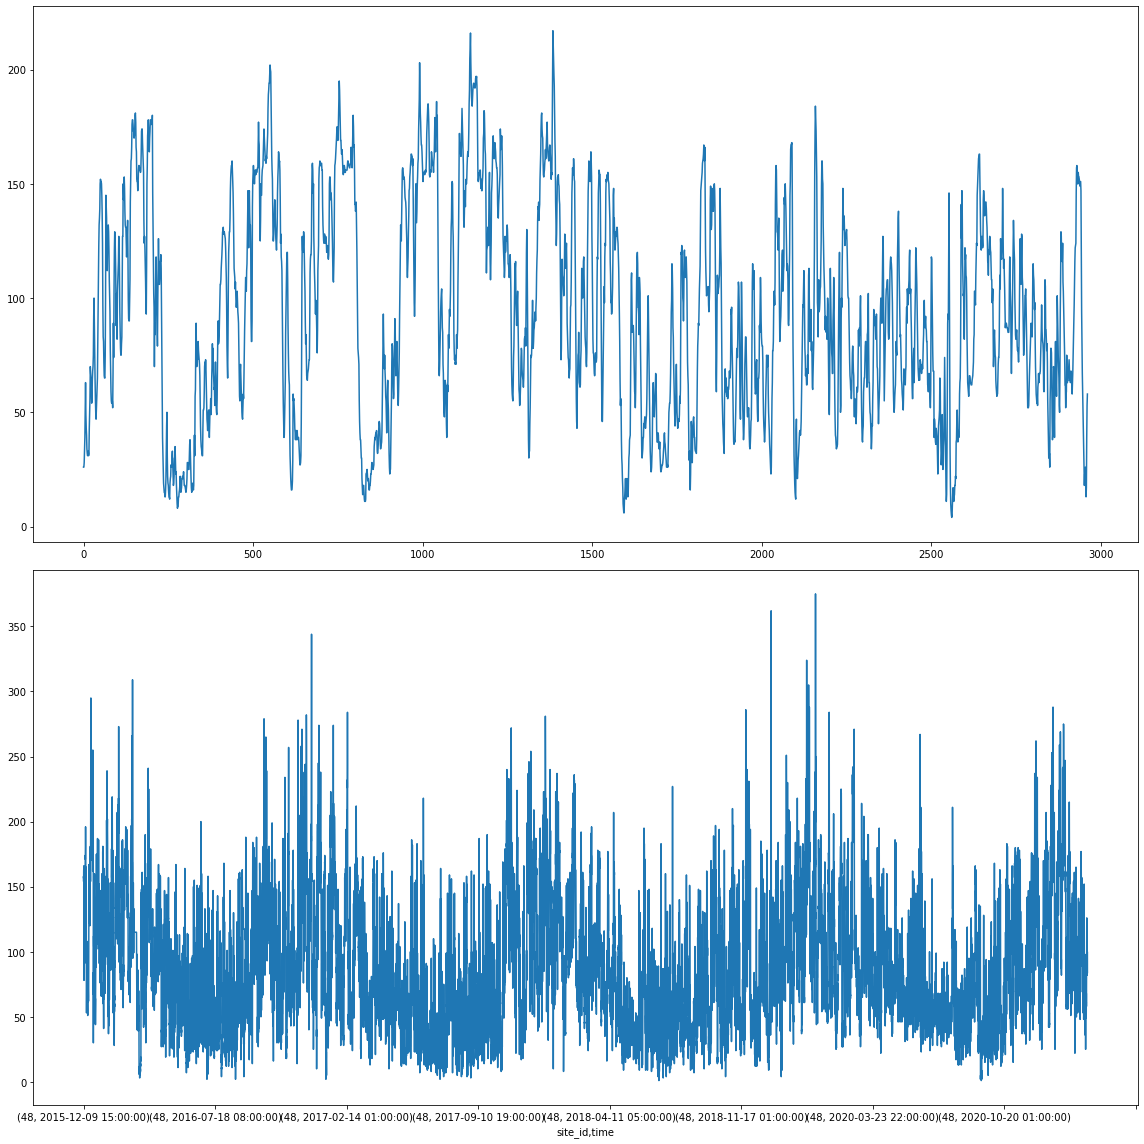

In [17]:
fig = plt.figure(figsize=(16,16))
gs = fig.add_gridspec(2, 1)
axe_1 = fig.add_subplot(gs[0,0])
axe_2 = fig.add_subplot(gs[1,0])
axe_1.plot(y=thudohanoi_df.loc[thudohanoi_df.index.get_level_values(0) == 47, 'PM25'].values)
thudohanoi_df.loc[thudohanoi_df.index.get_level_values(0) == 48, 'PM25'].plot()
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
import numpy as np
import glob
import xarray as xr

idx = pd.IndexSlice

root_path = "/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP"
_thudohanoi_data_path = root_path + '/Data/thudohanoi/refined_data'
_thudohanoi_files = glob.glob(_thudohanoi_data_path + '/*.csv')

thudohanoi_df = pd.DataFrame()
for file in _thudohanoi_files:
    print('Currently reading file \n{}'.format(file))
    thudohanoi_df = thudohanoi_df.append(pd.read_csv(file, parse_dates=True, index_col=['site_id', 'time'],
                                                    dtype={'CO': np.float64, 'NO2': np.float64,'PM25': np.float64,
                                                          'AQI_h': np.float64, 'AQI_h_I': np.int, 'site_id': np.int}))
    
# Remove site 16 because of some inconsistency in data
thudohanoi_df = thudohanoi_df[(thudohanoi_df.index.get_level_values(0) != 49)]

Currently reading file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/30.csv
Currently reading file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/9.csv
Currently reading file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/32.csv
Currently reading file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/11.csv
Currently reading file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/40.csv
Currently reading file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/28.csv
Currently reading file 
/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/Data/thudohanoi/refined_data/49.csv
Currently reading file 
/mnt/4ba37af6-51fd-47bc-8

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
scaler_PM25 = MinMaxScaler(feature_range=(-1,1))
scaler_PM25.fit(thudohanoi_df['PM25'].values.reshape(-1, 1))
scaler_AQI = MinMaxScaler(feature_range=(-1,1))
scaler_AQI.fit(thudohanoi_df['AQI_h'].values.reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [8]:
def reshape_array_and_save_to_path(arr_data, arr_label, path, timesteps, target_hour, data_type="Train"):
    # reshaping the array from 3D 
    # matrice to 2D matrice. 
    arr_data_reshaped = arr_data.reshape(arr_data.shape[0], -1)
    arr_label_reshaped = arr_label.reshape(arr_label.shape[0], -1)
    
    # saving reshaped array to file.
    saved_data = np.savez_compressed(path + "/{}_{}_{}_data.npz".format(timesteps, target_hour, data_type), arr_data_reshaped)
    saved_label = np.savez_compressed(path + "/{}_{}_{}_label.npz".format(timesteps, target_hour, data_type), arr_label_reshaped)
    
    # retrieving data from file.
    loaded_arr_data_file = np.load(path + "/{}_{}_{}_data.npz".format(timesteps, target_hour, data_type), allow_pickle=True)
    loaded_arr_label_file = np.load(path + "/{}_{}_{}_label.npz".format(timesteps, target_hour, data_type), allow_pickle=True)
    loaded_arr_data = loaded_arr_data_file['arr_0']
    loaded_arr_data_file.close()
    loaded_arr_label = loaded_arr_label_file['arr_0'].ravel()
    loaded_arr_label_file.close()
    # This loadedArr is a 2D array, therefore
    # we need to convert it to the original 
    # array shape.reshaping to get original 
    # matrice with original shape. 
    loaded_arr_data = loaded_arr_data.reshape( 
        loaded_arr_data.shape[0], loaded_arr_data.shape[1] // arr_data.shape[2], arr_data.shape[2])
    # check the shapes:
    print("Data array:")
    print("shape of arr: ", arr_data.shape) 
    print("shape of loaded_array: ", loaded_arr_data.shape)
    
    # check if both arrays are same or not: 
    if (arr_data == loaded_arr_data).all(): 
        print("Yes, both the arrays are same") 
    else: 
        print("No, both the arrays are not same")
    # check the shapes:
    print("Label array:")
    print("shape of arr: ", arr_label.shape) 
    print("shape of loaded_array: ", loaded_arr_label.shape)

    # check if both arrays are same or not: 
    if (arr_label == loaded_arr_label).all(): 
        print("Yes, both the arrays are same") 
    else: 
        print("No, both the arrays are not same")
    return None
def load_reshaped_array(timesteps, target_hour, folder_path, data_type="train"):
    features = np.load(folder_path + "/features.npy", allow_pickle=True).ravel()[0]
    loaded_file = np.load(folder_path + "/{}_{}_{}_data.npz".format(timesteps, target_hour, data_type), allow_pickle=True)
    loaded_data = loaded_file['arr_0']
    loaded_data = loaded_data.reshape( 
            loaded_data.shape[0], loaded_data.shape[1] // features, features).astype(float)
    loaded_file.close()
    loaded_file_label = np.load(folder_path + "/{}_{}_{}_label.npz".format(timesteps, target_hour, data_type), allow_pickle=True)
    loaded_label = loaded_file_label['arr_0'].ravel().astype(float)
    loaded_file_label.close()
    return loaded_data, loaded_label
def create_tensorflow_dataset(arr_data, arr_label, batch_size):
    tf_dataset = tf.data.Dataset.from_tensor_slices((arr_data, arr_label))
    tf_dataset = tf_dataset.repeat().batch(batch_size, drop_remainder=True)
    steps_per_epochs = len(arr_data) // batch_size
    return tf_dataset, steps_per_epochs

In [ ]:
# What we need to do:
# For each hour
# For each timestep
# Load the data
# Create the model
# Load the saved weights
# Create all 4 metrics
# Evaluate on the test set with 4 metrics.
# Plot that evaluation on a canvas

In [9]:
class Custom_ModelCheckPoint(keras.callbacks.Callback):
    def __init__(self, path, timesteps, target_hour):
        super(Custom_ModelCheckPoint, self).__init__()
        self.path = path
        self.timesteps = timesteps
        self.target_hour = target_hour

    def on_train_begin(self, logs=None):
        self.best_val = np.Inf

    # def on_train_end(self, logs=None):
    #     keys = list(logs.keys())
    #     print("Stop training; got log keys: {}".format(keys))

    # def on_epoch_begin(self, epoch, logs=None):
    #     keys = list(logs.keys())
    #     print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        current_train = logs.get('loss')
        current_val = logs.get('val_loss')
        if np.less_equal(abs(current_train - current_val), 0.05):
            if np.less_equal(current_val, self.best_val):
                self.best_val = current_val
                self.model.save_weights(self.path + get_model_weigts_name(self.timesteps, self.target_hour))

    # def on_test_begin(self, logs=None):
    #     keys = list(logs.keys())
    #     print("Start testing; got log keys: {}".format(keys))

    # def on_test_end(self, logs=None):
    #     keys = list(logs.keys())
    #     print("Stop testing; got log keys: {}".format(keys))

    # def on_predict_begin(self, logs=None):
    #     keys = list(logs.keys())
    #     print("Start predicting; got log keys: {}".format(keys))

    # def on_predict_end(self, logs=None):
    #     keys = list(logs.keys())
    #     print("Stop predicting; got log keys: {}".format(keys))

    # def on_train_batch_begin(self, batch, logs=None):
    #     keys = list(logs.keys())
    #     print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    # def on_train_batch_end(self, batch, logs=None):
    #     keys = list(logs.keys())
    #     print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    # def on_test_batch_begin(self, batch, logs=None):
    #     keys = list(logs.keys())
    #     print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    # def on_test_batch_end(self, batch, logs=None):
    #     keys = list(logs.keys())
    #     print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    # def on_predict_batch_begin(self, batch, logs=None):
    #     keys = list(logs.keys())
    #     print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    # def on_predict_batch_end(self, batch, logs=None):
    #     keys = list(logs.keys())
    #     print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))

In [10]:
class EarlyStoppingAtMinLossAndMinValLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLossAndMinValLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait_loss = 0
        self.wait_val_loss = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_val = np.Inf
        self.bet_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("loss")
        current_val_loss = logs.get("val_loss")
        if np.less_equal(current_loss, self.best_loss):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics, initializers
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import random
import pandas as pd
from os import mkdir

root_path = "/mnt/4ba37af6-51fd-47bc-8321-8c500c229114/study/School/KHOA LUAN TOT NGHIEP/"
_data_to_model_path = root_path + "Data/thudohanoi/data_to_model_hanoi/"
_model_path = root_path + "program/saved_models/latest_model/Hanoi/"
try:
    mkdir('{}program/saved_models/fig/'.format(root_path))
except FileExistsError:
    pass

def get_model_name(timesteps, target_hour):
    return 'model_{}_{}.h5'.format(timesteps, target_hour)

def get_model_weigts_name(timesteps, target_hour):
    return 'weights_{}_{}.ckpt'.format(timesteps, target_hour)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))
def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

for hour in [1]:
    rmse = []
    r2 = []
    mae = []
    mape = []
    for timestep in range(1, 13):    
        batch_size = 700
        test, y_test = load_reshaped_array(timestep, target_hour=hour, folder_path=_data_to_model_path, data_type="test")
        rand = random.randint(0, len(y_test)-40)
        if len(y_test) % batch_size != 0:
            remain_count = len(y_test)%batch_size
            test = test[remain_count:]
            y_test = y_test[remain_count:]
        test_data_tf, test_steps_per_epochs = create_tensorflow_dataset(test, y_test, batch_size)
        
#         model = create_model(batch_size=batch_size, timestep=timestep,features=7, dropout = 0.2)
        model = keras.models.load_model(root_path + 'program/saved_models/latest_model/Hanoi/{}/model_of_{}_hour/{}'.format(
            timestep, hour, get_model_name(timestep, hour)),
                                custom_objects={'LeakyReLU': layers.LeakyReLU(alpha=0.01),
                                               'root_mean_squared_error': root_mean_squared_error})
        model.load_weights('{}{}/model_of_{}_hour/{}'.format(_model_path, timestep, hour,
                                         get_model_weigts_name(timesteps=timestep, target_hour=hour))).expect_partial()
        predict = model.predict(test_data_tf, steps=test_steps_per_epochs).ravel()
        scaler_AQI = MinMaxScaler(feature_range=(-1,1))
        scaler_AQI.fit(thudohanoi_df['AQI_h'].values.reshape(-1, 1))
        y_test = scaler_AQI.inverse_transform(y_test.reshape(-1, 1))
        predict = scaler_AQI.inverse_transform(predict.reshape(-1, 1))
        print("=============================================\n")
#         print("Predict")
#         predict_vs_truth = pd.DataFrame({'predict': predict[rand:rand+20],
#                                         'truth': y_test[rand:rand+20]})
#         print(predict_vs_truth)
        print("R2: {}".format(r2_score(predict, y_test)))
        print("Root mean squared error: {}".format(mean_squared_error(predict, y_test, squared=False)))
        print("Mean absolute percentage error: {}".format(mean_absolute_percentage_error(predict, y_test)))
        print("Mean absolute error: {}".format(mean_absolute_error(predict, y_test)))
        
        rmse.append(mean_squared_error(predict, y_test, squared=False))
        r2.append(r2_score(predict, y_test))
        mape.append(mean_absolute_percentage_error(predict, y_test))
        mae.append(mean_absolute_error(predict, y_test))
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    ax.plot(range(1,13),rmse)
    ax.plot(range(1,13),r2)
    ax.plot(range(1,13),mape)
    ax.plot(range(1,13),mae)
#         axes = [0, 0]
#         axes[0] = fig.add_subplot(gs[0,0])
#         axes[1] = fig.add_subplot(gs[1,0])
#         axes[0].plot(y_test)
#         axes[1].plot(predict)

#         fig.suptitle("Timestep {}".format(timesteps))
#         fig.save_fig("{}_{}.png".format(timesteps, counter))
plt.show()

ValueError: in user code:

    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/wrappers.py:539 __call__
        return super(Bidirectional, self).__call__(inputs, **kwargs)
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/wrappers.py:652 call
        y = self.forward_layer(forward_inputs,
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/nam/Development/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer forward_lstm: expected shape=(700, None, 128), found shape=(1000, 1, 128)


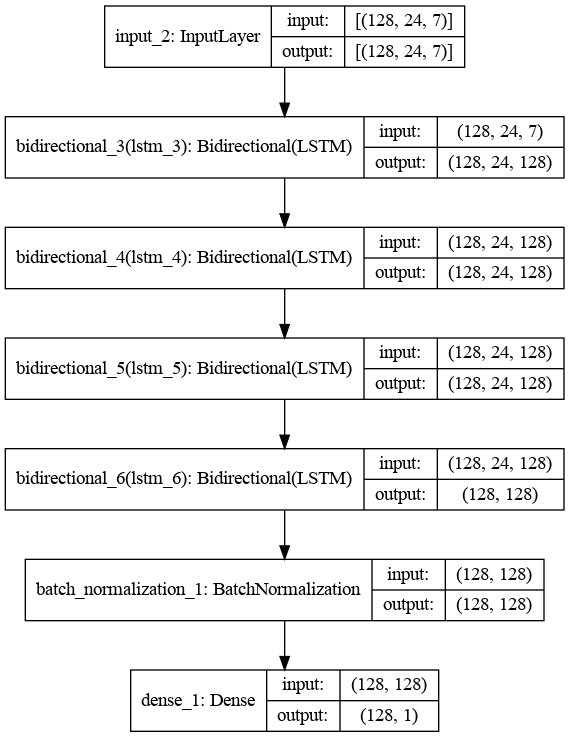

In [14]:
model = create_model(128, 24, 7, 0.2, 2, True)
keras.utils.plot_model(model, "sample model.png", show_shapes=True)

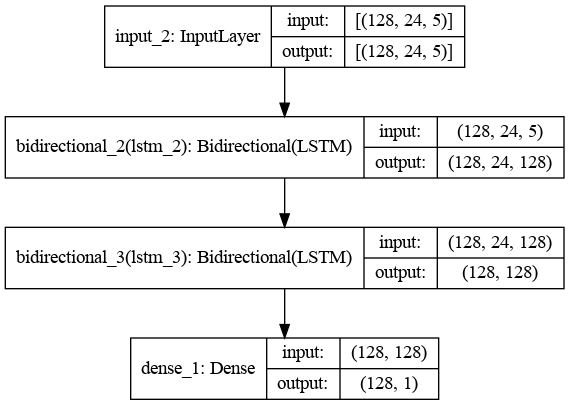

In [9]:
model = keras.models.load_model(root_path + '/program/saved_models/latest_model/model_1_24.h5',
                                custom_objects={'LeakyReLU': layers.LeakyReLU(alpha=0.01),
                                               'root_mean_squared_error': root_mean_squared_error})
keras.utils.plot_model(model, "sample model.png", show_shapes=True)

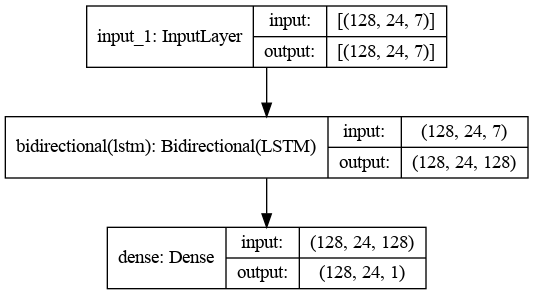

In [10]:
model = keras.models.load_model(root_path + '/program/saved_models/experimental/{}/model_of_1_hour/model_{}.h5'.format(24,1),
                                custom_objects={'LeakyReLU': layers.LeakyReLU(alpha=0.01),
                                               'root_mean_squared_error': root_mean_squared_error})
keras.utils.plot_model(model, "sample model.png", show_shapes=True)

In [30]:
y_test.shape

(11764,)

In [29]:
predict.shape

(11648, 24, 1)

In [27]:
predict = model.predict(test_data_tf, steps=test_steps_per_epochs)

In [22]:
test, y_test = load_reshaped_array(24, 1, 7, folder_path=_data_to_model_path, data_type="test")
test_data_tf, test_steps_per_epochs = create_tensorflow_dataset(test, y_test, batch_size)